In [1]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import yfinance as yf  # For downloading stock data
import ta  # For technical analysis indicators
from sklearn.preprocessing import RobustScaler  # For scaling features
from sklearn.model_selection import TimeSeriesSplit  # For time series cross-validation
from sklearn.ensemble import GradientBoostingRegressor  # Gradient Boosting model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error  # For model evaluation
from sklearn.feature_selection import SelectFromModel  # For feature selection
from sklearn.pipeline import Pipeline  # For creating a model pipeline
from sklearn.base import BaseEstimator, TransformerMixin  # For custom transformers
from sklearn.impute import SimpleImputer# For handling missing values
from sklearn.feature_selection import RFECV, mutual_info_regression
from xgboost import XGBRegressor  # XGBoost model
from lightgbm import LGBMRegressor  # LightGBM model
from keras.models import Sequential  # For building neural networks
from keras.layers import LSTM, Dense, Dropout  # Layers for LSTM model
from keras.optimizers import Adam  # Adam optimizer for neural networks
import optuna  # For hyperparameter optimization
from statsmodels.tsa.statespace.sarimax import SARIMAX  # For SARIMA modeling
from prophet import Prophet  # Facebook's Prophet model for time series forecasting
import matplotlib.pyplot as plt  # For plotting
import shap  # For model interpretability
from textblob import TextBlob  # For sentiment analysis
import requests  # For making HTTP requests
import json
from scipy.stats import spearmanr
from statsmodels.tsa.holtwinters import ExponentialSmoothing  # For Holt-Winters' exponential smoothing
from pmdarima import auto_arima  # For automatic ARIMA modeling
from sklearn.linear_model import ElasticNet  # Elastic Net regression
from sklearn.ensemble import VotingRegressor  # For ensemble modeling
from datetime import datetime, timedelta  # For date and time operations
import pytz  # For timezone handling
import torch  # PyTorch for deep learning
import torch.nn as nn  # Neural network modules
import torch.optim as optim  # Optimization algorithms
from torch.utils.data import DataLoader, TensorDataset  # For data loading
from transformers import TimeSeriesTransformerModel, TimeSeriesTransformerConfig  # For time series transformers
import gym  # For reinforcement learning environments
from stable_baselines3 import PPO  # Proximal Policy Optimization algorithm
from stable_baselines3.common.vec_env import DummyVecEnv  # For vectorized environments
import warnings  # For handling warnings
from sklearn.feature_selection import RFECV  # Recursive Feature Elimination with Cross-Validation
from sklearn.linear_model import LassoCV  # Lasso regression with built-in cross-validation

warnings.filterwarnings('ignore')

In [2]:
def get_bitcoin_data_yfinance_format(start_date, end_date):
    """
    Fetching Bitcoin price data from multiple sources and combining them into a single DataFrame.

    This function retrieves data from yfinance for dates before 2019-01-24,
    and from CryptoCompare for dates from 2019-01-24 onwards. We use this hybrid 
    approach because CryptoCompare doesn't have data before 2019-01-24, and we 
    prefer to use CryptoCompare for more recent data as it provides more up-to-date 
    and point-in-time accurate information for cryptocurrency prices.
    
    """
    # Converting date strings to datetime objects in UTC
    start_dt = pd.to_datetime(start_date).tz_localize('UTC')
    end_dt = pd.to_datetime(end_date).tz_localize('UTC')

    # Defining the split date (2019-01-24)
    split_date = pd.Timestamp('2019-01-24').tz_localize('UTC')

    # Fetching data from yfinance for dates before 2019-01-24
    if start_dt < split_date:
        yf_end_date = min(split_date, end_dt)
        yf_data = yf.download("BTC-USD", start=start_dt, end=yf_end_date)
        yf_data = yf_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        yf_data.index = yf_data.index.tz_localize('UTC') 
    else:
        yf_data = pd.DataFrame()

    # Fetching data from CryptoCompare for dates from 2019-01-24 onwards
    if end_dt >= split_date:
        cc_start_date = max(start_dt, split_date)
        cc_end_ts = int(end_dt.timestamp())
        cc_days_diff = (end_dt - cc_start_date).days + 1

        url = "https://min-api.cryptocompare.com/data/v2/histoday"
        limit = min(cc_days_diff, 2000) 

        params = {
            "fsym": "BTC",
            "tsym": "USD",
            "limit": limit,
            "toTs": cc_end_ts
        }
        response = requests.get(url, params=params)

        if response.status_code == 200:
            data = response.json()['Data']['Data']
            cc_data = pd.DataFrame(data)
            cc_data['Date'] = pd.to_datetime(cc_data['time'], unit='s', utc=True)
            cc_data.set_index('Date', inplace=True)
            cc_data = cc_data[['open', 'high', 'low', 'close', 'volumefrom']]
            cc_data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
            cc_data['Adj Close'] = cc_data['Close']

            # Round price columns to 6 decimal places
            for col in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
                cc_data[col] = cc_data[col].round(6)

            # Converting volume to integer
            cc_data['Volume'] = (cc_data['Volume'] * 1000).astype(int)

            cc_data = cc_data[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
        else:
            raise Exception(f"Error fetching data: HTTP {response.status_code}")
    else:
        cc_data = pd.DataFrame()

    df = pd.concat([yf_data, cc_data])
    df = df[~df.index.duplicated(keep='last')]  


    if df.index.tz is None:
        df.index = df.index.tz_localize('UTC')

    df.sort_index(inplace=True)

    df = df.loc[start_dt:end_dt]

    return df

start_date = "2015-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")
df = get_bitcoin_data_yfinance_format(start_date, end_date)

print("DataFrame Info:")
print(df.info())

print("\nFirst few rows:")
print(df.head())

print("\nColumn Data Types:")
print(df.dtypes)

print("\nSummary Statistics:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

[*********************100%%**********************]  1 of 1 completed


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3485 entries, 2015-01-01 00:00:00+00:00 to 2024-08-22 00:00:00+00:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3485 non-null   float64
 1   High       3485 non-null   float64
 2   Low        3485 non-null   float64
 3   Close      3485 non-null   float64
 4   Adj Close  3485 non-null   float64
 5   Volume     3485 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 190.6 KB
None

First few rows:
                                 Open        High         Low       Close  \
Date                                                                        
2015-01-01 00:00:00+00:00  320.434998  320.434998  314.002991  314.248993   
2015-01-02 00:00:00+00:00  314.079010  315.838989  313.565002  315.032013   
2015-01-03 00:00:00+00:00  314.846008  315.149994  281.082001  281.082001   
2015-01-04 00:00:00+00:00  281.145996  287.230011  

In [3]:
# Loading data from 2015-01-01 to the latest available date
start_date = "2015-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")

# Fetching Bitcoin data using a custom function 
df = get_bitcoin_data_yfinance_format(start_date, end_date)

print(f"Using data from {df.index[0]} to {df.index[-1]}")

def get_crypto_sentiment():
    """
    This function uses the free tier of the CryptoPanic API to retrieve recent cryptocurrency
    news and posts. It then performs basic sentiment analysis on the post titles using
    TextBlob, a simple NLP library. While this approach provides a quick and cost-effective
    way to gauge market sentiment, it has limitations in terms of accuracy and depth of analysis.

    Returns:
    float: Average sentiment score (-1 to 1, where -1 is very negative, 0 is neutral, and 1 is very positive)

    Note:
    - This function requires a free API key from CryptoPanic. Replace 'API_KEY' in the URL with your actual key.

    """
    try:
        # CryptoPanic API endpoint (replace API_KEY with your actual API key)
        url = "https://cryptopanic.com/api/v1/posts/?auth_token=API_KEY&currencies=BTC"
    
        response = requests.get(url, timeout=10)
        response.raise_for_status()  
        
        data = response.json()
        
        # Calculating sentiment scores for each post title
        sentiment_scores = []
        for post in data['results']:
            text = post['title']
            blob = TextBlob(text)
            sentiment_scores.append(blob.sentiment.polarity)
        
        
        return np.mean(sentiment_scores) if sentiment_scores else 0
    
    except requests.RequestException as e:
    
        print(f"Error fetching sentiment data: {e}")
        return 0  
    
    except json.JSONDecodeError as e:
        
        print(f"Error decoding JSON: {e}")
        return 0  
    
    except Exception as e:
        
        print(f"Unexpected error in get_crypto_sentiment: {e}")
        return 0 

[*********************100%%**********************]  1 of 1 completed


Using data from 2015-01-01 00:00:00+00:00 to 2024-08-22 00:00:00+00:00


In [4]:
# Function to classify ROI predictions
def classify_prediction(roi):
    """
    Classifies the Return on Investment (ROI) prediction into categories.
    
    """
    if roi <= -0.08:
        return "Strong Bear"
    elif -0.08 < roi <= 0:
        return "Weak Bear"
    elif 0 < roi <= 0.06:
        return "Choppy"
    elif 0.06 < roi <= 0.16:
        return "Weak Bull"
    else:
        return "Strong Bull"

# Custom transformer for Recursive Feature Elimination with Cross-Validation
class RFECVTransformer(BaseEstimator, TransformerMixin):
    """
    A custom transformer that performs feature selection using SelectFromModel.

    This transformer is designed to work with scikit-learn's pipeline and
    cross-validation tools.
    """
    def __init__(self, estimator, step=1, cv=5):

        self.estimator = estimator
        self.step = step
        self.cv = cv
        self.selector = SelectFromModel(estimator=estimator, threshold='median')

    def fit(self, X, y=None):
        
        self.selector.fit(X, y)
        return self

    def transform(self, X):

        return self.selector.transform(X)

# Function to calculate double exponential moving average
def double_ema(data, period=30):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    return 2 * ema1 - ema2

In [5]:
def engineer_features(df):
    # Check if there's enough data to calculate all features
    if len(df) < 365:
        print("Warning: Not enough data to calculate all features. Returning original DataFrame.")
        return df

    # Calculate 7-day Return on Investment (ROI)
    df['7d_ROI'] = df['Close'].pct_change(7)

    # 7-day percentage change in closing price
    df['Close_Pct_Change_7'] = df['Close'].pct_change(periods=7)
    # 7-day Rate of Change (ROC)
    df['ROC_7'] = (df['Close'] - df['Close'].shift(7)) / df['Close'].shift(7) * 100
    # Price Momentum (ratio of current price to 10-day moving average)
    df['Price_Momentum'] = df['Close'] / df['Close'].rolling(window=min(10, len(df))).mean() - 1
    # Keltner Channel Width (measure of volatility)
    df['Keltner_Channel_Width'] = ta.volatility.KeltnerChannel(df['High'], df['Low'], df['Close']).keltner_channel_wband()

    # 14-day percentage change in closing price
    df['Close_Pct_Change_14'] = df['Close'].pct_change(periods=14)
    # 14-day Rate of Change (ROC)
    df['ROC_14'] = (df['Close'] - df['Close'].shift(14)) / df['Close'].shift(14) * 100
    # 30-day Rate of Change (ROC)
    df['ROC_30'] = (df['Close'] - df['Close'].shift(30)) / df['Close'].shift(30) * 100

    # Volatility features
    # Ratio of short-term (10-day) to long-term (30-day) volatility
    for lag in [1, 3, 7]:
        df[f'Volatility_Ratio_Lag_{lag}'] = (df['High'] - df['Low']).rolling(window=10).std().shift(lag) / (df['High'] - df['Low']).rolling(window=30).std().shift(lag)

    # Volume features
    # Percentage change in volume over different time periods
    for lag in [150, 240]:
        df[f'Volume_Lag_{lag}'] = df['Volume'].pct_change(lag)

    # Trend indicators
    # Aroon Indicator (measures the strength of a trend)
    aroon = ta.trend.AroonIndicator(df['High'], df['Low'])
    df['Aroon_Up_Lag_1'] = aroon.aroon_up().shift(1)
    df['Aroon_Down_Lag_1'] = aroon.aroon_down().shift(1)

    # Momentum indicators
    # MACD (Moving Average Convergence Divergence)
    macd = ta.trend.MACD(df['Close'])
    df['MACD'] = macd.macd()
    df['MACD_Signal'] = macd.macd_signal()
    df['MACD_Diff'] = macd.macd_diff()
    for lag in [1, 3, 7]:
        df[f'MACD_Diff_Lag_{lag}'] = df['MACD_Diff'].shift(lag)

    # Additional features
    # Zigzag Indicator (identifies potential reversal points)
    df['Zigzag_Indicator_Lag_1'] = (df['Close'] - df['Close'].rolling(window=20).min()) / (df['Close'].rolling(window=20).max() - df['Close'].rolling(window=20).min()).shift(1)
    df['Zigzag_Indicator_Lag_3'] = (df['Close'] - df['Close'].rolling(window=20).min()) / (df['Close'].rolling(window=20).max() - df['Close'].rolling(window=20).min()).shift(3)

    # RSI features (Relative Strength Index)
    for window in [14, 30]:
        df[f'RSI_{window}'] = ta.momentum.RSIIndicator(df['Close'], window=window).rsi()
        for lag in [1, 3, 7]:
            df[f'RSI_{window}_Lag_{lag}'] = df[f'RSI_{window}'].shift(lag)

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(df['Close'])
    df['BB_Width'] = bb.bollinger_wband()
    df['BB_Width_Lag_1'] = df['BB_Width'].shift(1)
    df['BB_Width_Lag_3'] = df['BB_Width'].shift(3)

    # Moving Averages
    df['SMA_50'] = df['Close'].rolling(window=50).mean()
    df['SMA_200'] = df['Close'].rolling(window=200).mean()
    df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()

    # DEMA (Double Exponential Moving Average)
    def DEMA(data, period):
        ema = data.ewm(span=period, adjust=False).mean()
        dema = 2 * ema - ema.ewm(span=period, adjust=False).mean()
        return dema

    df['DEMA_20'] = DEMA(df['Close'], 20)
    df['DEMA_50'] = DEMA(df['Close'], 50)

    # Fibonacci Retracement levels
    df['Fib_38.2'] = df['Low'] + 0.382 * (df['High'] - df['Low'])
    df['Fib_61.8'] = df['Low'] + 0.618 * (df['High'] - df['Low'])
    for lag in [1, 3]:
        df[f'Fib_38.2_Lag_{lag}'] = df['Fib_38.2'].shift(lag)
        df[f'Fib_61.8_Lag_{lag}'] = df['Fib_61.8'].shift(lag)

    # Stochastic Oscillator
    stoch = ta.momentum.StochasticOscillator(df['High'], df['Low'], df['Close'])
    df['Stoch_K'] = stoch.stoch()
    df['Stoch_D'] = stoch.stoch_signal()
    for lag in [1, 3]:
        df[f'Stoch_K_Lag_{lag}'] = df['Stoch_K'].shift(lag)
        df[f'Stoch_D_Lag_{lag}'] = df['Stoch_D'].shift(lag)

    return df

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

def advanced_feature_selection(X, y, n_splits=5, verbose=True):
    """
    Performing advanced feature selection using multiple methods.
    
    """
    # Initialize TimeSeriesSplit for cross-validation
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Define a custom scoring function that combines MSE and Spearman correlation
    def custom_score(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        corr, _ = spearmanr(y_true, y_pred)
        return -mse * (1 + corr) / 2 

    custom_scorer = make_scorer(custom_score, greater_is_better=True)

    # Recursive Feature Elimination with Cross-Validation (RFECV) using XGBoost
    xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
    rfecv = RFECV(estimator=xgb_model, step=1, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1, min_features_to_select=1)
    rfecv.fit(X, y)
    rfecv_features = X.columns[rfecv.support_].tolist()

    # LASSO feature selection
    lasso = LassoCV(cv=tscv, random_state=42, n_jobs=-1)
    lasso.fit(X, y)
    
    lasso_features = X.columns[np.abs(lasso.coef_) > np.percentile(np.abs(lasso.coef_), 75)].tolist()

    # Random Forest feature importance
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model.fit(X, y)
   
    importance_threshold = np.percentile(rf_model.feature_importances_, 75)
    rf_features = X.columns[rf_model.feature_importances_ > importance_threshold].tolist()

    # Mutual Information feature selection
    mi_scores = mutual_info_regression(X, y)
  
    mi_threshold = np.percentile(mi_scores, 75)
    mi_features = X.columns[mi_scores > mi_threshold].tolist()

    # Combine all selected features 
    selected_features = list(set(rfecv_features) | set(lasso_features) | set(rf_features) | set(mi_features))

    if verbose:
        print(f"RFECV selected {len(rfecv_features)} features")
        print(f"LASSO selected {len(lasso_features)} features")
        print(f"Random Forest selected {len(rf_features)} features")
        print(f"Mutual Information selected {len(mi_features)} features")
        print(f"Combined selection: {len(selected_features)} features")

        
        feature_importance = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
        print("\nTop 10 features by Random Forest importance:")
        for importance, feature in feature_importance[:10]:
            print(f"{feature}: {importance:.4f}")

   
    if len(selected_features) < 5:
        print("Too few features selected. Using top 10 features by Random Forest importance.")
        return [feature for _, feature in feature_importance[:10]]

    return selected_features


In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel

df = yf.download("BTC-USD", start=start_date, end=end_date)

# Engineer features 
df = engineer_features(df)

# Data Cleaning
df = df.dropna()

df = df.select_dtypes(include=[np.number])

# Feature Selection
X = df.drop('7d_ROI', axis=1)
y = df['7d_ROI']

selected_features = advanced_feature_selection(X, y)
X = X[selected_features]

# Train-Test Split
train_size = int(len(X) * 0.8)
split_date = X.index[train_size]
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:split_date], y[split_date:]

train_index = X_train.index
test_index = X_test.index

# Function to clean target variable
def clean_target_variable(y):
    y = y.replace([np.inf, -np.inf], np.nan).dropna()
    mean = y.mean()
    std = y.std()
    y = y[(y > mean - 5*std) & (y < mean + 5*std)]

    return y

X = df[selected_features]
y = clean_target_variable(df['7d_ROI'])
X = X.loc[y.index]

# LSTM Model Definition
def create_lstm_model(input_shape, dropout_rate=0.5, neurons=[512, 256, 128]):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(neurons[0], input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))

    # Additional LSTM layers
    for units in neurons[1:-1]:
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(dropout_rate))

    # Final LSTM layer
    model.add(LSTM(neurons[-1]))
    model.add(Dropout(dropout_rate))

    # Output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

    return model

# Transformer Model Definition
def create_transformer_model(input_shape):
    config = TimeSeriesTransformerConfig(
        d_model=64,
        n_heads=4,
        n_layers=4,
        dim_feedforward=256,
        dropout=0.1,
        activation="gelu",
        context_length=input_shape[0],
        prediction_length=1
    )
    model = TimeSeriesTransformerModel(config)
    return model

[*********************100%%**********************]  1 of 1 completed


RFECV selected 4 features
LASSO selected 1 features
Random Forest selected 14 features
Mutual Information selected 14 features
Combined selection: 20 features

Top 10 features by Random Forest importance:
Close_Pct_Change_7: 0.5254
ROC_7: 0.4689
Volume_Lag_240: 0.0012
Close_Pct_Change_14: 0.0008
Price_Momentum: 0.0007
Stoch_K: 0.0003
ROC_14: 0.0003
Zigzag_Indicator_Lag_3: 0.0003
Volatility_Ratio_Lag_7: 0.0003
RSI_30: 0.0002


In [8]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import mean_squared_error

class CustomImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.knn_imputer = KNNImputer(n_neighbors=5)
        self.median_imputer = SimpleImputer(strategy='median')

    def fit(self, X, y=None):
        self.cont_features = X.select_dtypes(include=['float64', 'int64']).columns
        self.other_features = X.columns.difference(self.cont_features)
        if not self.cont_features.empty:
            self.knn_imputer.fit(X[self.cont_features])
        if not self.other_features.empty:
            self.median_imputer.fit(X[self.other_features])

        return self

    def transform(self, X):
        X_transformed = X.copy()
        if not self.cont_features.empty:
            X_cont = pd.DataFrame(
                self.knn_imputer.transform(X[self.cont_features]),
                columns=self.cont_features,
                index=X.index
            )
            X_transformed[self.cont_features] = X_cont
        if not self.other_features.empty:
            X_other = pd.DataFrame(
                self.median_imputer.transform(X[self.other_features]),
                columns=self.other_features,
                index=X.index
            )
            X_transformed[self.other_features] = X_other

        return X_transformed

# Objective function for hyperparameter optimization
def objective(trial, X, y, cv, preprocessor):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10)
    }

    model = XGBRegressor(**params, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_processed = preprocessor.fit_transform(X_train)
        X_val_processed = preprocessor.transform(X_val)
        model.fit(X_train_processed, y_train)
        pred = model.predict(X_val_processed)
        score = mean_squared_error(y_val, pred)
        scores.append(score)
    return np.mean(scores)

In [9]:
class ExtremeValueHandler(BaseEstimator, TransformerMixin):

    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transformed = X.copy()

        for column in X.columns:
            # mean and standard deviation for the column
            mean = X[column].mean()
            std = X[column].std()

            # Cliping values outside the range [mean - threshold * std, mean + threshold * std]
            X_transformed[column] = X[column].clip(
                lower=mean - self.threshold * std,
                upper=mean + self.threshold * std
            )

        return X_transformed

In [10]:
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score

# Custom transformer to handle extreme values
class ExtremeValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=3):
        self.threshold = threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in X_copy.columns:
            if X_copy[column].dtype in ['int64', 'float64']:
                # Calculating IQR and bounds
                Q1 = X_copy[column].quantile(0.25)
                Q3 = X_copy[column].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.threshold * IQR
                upper_bound = Q3 + self.threshold * IQR
                # Clip values to the bounds
                X_copy[column] = X_copy[column].clip(lower_bound, upper_bound)
        return X_copy

# Custom transformer to filter highly correlated features
class CorrelationFilter(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold

    def fit(self, X, y=None):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        self.corr_matrix = X.corr().abs()
        return self

    def transform(self, X):
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        upper = self.corr_matrix.where(np.triu(np.ones(self.corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper.columns if any(upper[column] > self.threshold)]
        return X.drop(columns=to_drop)

# Wrapper to ensure transformers return DataFrames
class DataFrameWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None):
        self.transformer.fit(X, y)
        return self

    def transform(self, X):
        result = self.transformer.transform(X)
        if isinstance(result, np.ndarray):
            return pd.DataFrame(result, columns=X.columns, index=X.index)
        return result

def create_pipeline(trial):
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
    categorical_features = X.select_dtypes(include=['object', 'category']).columns

    # Numeric data preprocessing
    numeric_transformer = Pipeline([
        ('extreme_value_handler', ExtremeValueHandler(threshold=trial.suggest_float('evh_threshold', 2, 4))),
        ('imputer', KNNImputer(n_neighbors=trial.suggest_int('knn_neighbors', 3, 7))),
        ('scaler', RobustScaler()),
        ('qt', QuantileTransformer(n_quantiles=trial.suggest_int('qt_quantiles', 100, 1000), output_distribution='normal')),
    ])

    # Categorical data preprocessing
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
    ])

    # Combining numeric and categorical preprocessors
    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
    ])

    preprocessor = DataFrameWrapper(preprocessor)

    # Feature selection pipeline
    feature_selector = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=trial.suggest_float('vt_threshold', 0.005, 0.02))),
        ('correlation_filter', CorrelationFilter(threshold=trial.suggest_float('corr_threshold', 0.9, 0.99))),
        ('univariate_selection', SelectKBest(score_func=f_regression, k=trial.suggest_int('k_best', 10, len(X.columns)))),
        ('pca', PCA(n_components=trial.suggest_float('pca_components', 0.8, 0.99))),
    ])

    # XGBoost model with hyperparameters 
    model = XGBRegressor(
        n_estimators=trial.suggest_int('n_estimators', 50, 300),
        max_depth=trial.suggest_int('max_depth', 3, 10),
        learning_rate=trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        subsample=trial.suggest_uniform('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        min_child_weight=trial.suggest_int('min_child_weight', 1, 10),
        random_state=42
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selector', feature_selector),
        ('model', model),
    ])

    return pipeline

# Objective function for Optuna 
def objective(trial):
    pipeline = create_pipeline(trial)
    scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    return -scores.mean()

def optimize_pipeline(X, y, n_trials=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    best_pipeline = create_pipeline(study.best_trial)
    best_pipeline.fit(X, y)

    return best_pipeline, study.best_trial

X = df.drop('7d_ROI', axis=1)
y = df['7d_ROI']

best_pipeline, best_trial = optimize_pipeline(X, y, n_trials=100)

print("Best hyperparameters:", best_trial.params)
print("Best cross-validated MSE:", -best_trial.value)

[I 2024-08-22 23:31:08,433] A new study created in memory with name: no-name-944fa289-13a9-417a-9ff0-d80b82583005
[I 2024-08-22 23:31:11,079] Trial 0 finished with value: 0.0023981597858777114 and parameters: {'evh_threshold': 3.214642739882671, 'knn_neighbors': 3, 'qt_quantiles': 676, 'vt_threshold': 0.011774932596548274, 'corr_threshold': 0.9093198570081922, 'k_best': 25, 'pca_components': 0.9056621684858661, 'n_estimators': 297, 'max_depth': 10, 'learning_rate': 0.040817965998691495, 'subsample': 0.9793622691283526, 'colsample_bytree': 0.9151231814936054, 'min_child_weight': 6}. Best is trial 0 with value: 0.0023981597858777114.
[I 2024-08-22 23:31:11,666] Trial 1 finished with value: 0.003427414942613771 and parameters: {'evh_threshold': 3.4048009077173997, 'knn_neighbors': 4, 'qt_quantiles': 114, 'vt_threshold': 0.017424557009171865, 'corr_threshold': 0.938422400753448, 'k_best': 23, 'pca_components': 0.8564268352317461, 'n_estimators': 278, 'max_depth': 9, 'learning_rate': 0.1929

Best hyperparameters: {'evh_threshold': 3.7742911056844073, 'knn_neighbors': 5, 'qt_quantiles': 698, 'vt_threshold': 0.014793453580795117, 'corr_threshold': 0.9105293416122879, 'k_best': 11, 'pca_components': 0.9746132599407227, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.1986775156336432, 'subsample': 0.8315066675541654, 'colsample_bytree': 0.7941262853944038, 'min_child_weight': 10}
Best cross-validated MSE: -0.00029977758011478817


In [11]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

# Custom transformer to handle extreme values
class ExtremeValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, replace_inf=True, replace_large=True, large_threshold=1e300):
        self.replace_inf = replace_inf
        self.replace_large = replace_large
        self.large_threshold = large_threshold

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()

        if self.replace_inf:
            X = X.replace([np.inf, -np.inf], np.nan)

        if self.replace_large:
            X = X.mask(X.abs() > self.large_threshold, np.nan)

        return X

selected_features = advanced_feature_selection(X, y)

X = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_index = y_train.index
test_index = y_test.index

preprocessor = Pipeline([
    ('extreme_value_handler', ExtremeValueHandler()),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

print(f"Shape of X_train after processing: {X_train.shape}")
print(f"Shape of X_test after processing: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

print(f"Any infinity values in X_train: {np.isinf(X_train).any().any()}")
print(f"Any infinity values in X_test: {np.isinf(X_test).any().any()}")
print(f"Any NaN values in X_train: {np.isnan(X_train).any().any()}")
print(f"Any NaN values in X_test: {np.isnan(X_test).any().any()}")

RFECV selected 4 features
LASSO selected 1 features
Random Forest selected 14 features
Mutual Information selected 14 features
Combined selection: 20 features

Top 10 features by Random Forest importance:
Close_Pct_Change_7: 0.5254
ROC_7: 0.4689
Volume_Lag_240: 0.0012
Close_Pct_Change_14: 0.0008
Price_Momentum: 0.0007
Stoch_K: 0.0003
ROC_14: 0.0003
Zigzag_Indicator_Lag_3: 0.0003
Volatility_Ratio_Lag_7: 0.0003
RSI_30: 0.0002
Shape of X_train after processing: (2624, 20)
Shape of X_test after processing: (657, 20)
Shape of y_train: (2624,)
Shape of y_test: (657,)
Any infinity values in X_train: False
Any infinity values in X_test: False
Any NaN values in X_train: False
Any NaN values in X_test: False


In [12]:
def optunaobjective(trial, X, y, cv, preprocessor):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 10)
    }

    model = XGBRegressor(**params, random_state=42)
    scores = []

    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        X_train_processed = preprocessor.fit_transform(X_train)
        X_val_processed = preprocessor.transform(X_val)

        model.fit(X_train_processed, y_train)
        pred = model.predict(X_val_processed)

        score = mean_squared_error(y_val, pred)
        scores.append(score)

    return np.mean(scores)

cv = TimeSeriesSplit(n_splits=5)

study = optuna.create_study(direction='minimize')

study.optimize(lambda trial: optunaobjective(trial, X, y, cv, preprocessor), n_trials=500)

best_params = study.best_params

[I 2024-08-22 23:32:59,614] A new study created in memory with name: no-name-7cd5e220-8ba8-42f3-9d11-53777610a204
[I 2024-08-22 23:33:01,406] Trial 0 finished with value: 0.00015477824313888552 and parameters: {'n_estimators': 695, 'max_depth': 5, 'learning_rate': 0.040797843038424736, 'subsample': 0.6497019064537138, 'subsample_freq': 10}. Best is trial 0 with value: 0.00015477824313888552.
[I 2024-08-22 23:33:01,906] Trial 1 finished with value: 0.0001674824990780649 and parameters: {'n_estimators': 355, 'max_depth': 10, 'learning_rate': 0.33878414022791065, 'subsample': 0.9119261723556285, 'subsample_freq': 8}. Best is trial 0 with value: 0.00015477824313888552.
[I 2024-08-22 23:33:04,148] Trial 2 finished with value: 0.0004945638470688522 and parameters: {'n_estimators': 330, 'max_depth': 9, 'learning_rate': 0.00588131492956293, 'subsample': 0.8903674388272338, 'subsample_freq': 7}. Best is trial 0 with value: 0.00015477824313888552.
[I 2024-08-22 23:33:04,975] Trial 3 finished wit

In [13]:
# Gradient Boosting Regressor
gb_best = GradientBoostingRegressor(n_estimators=best_params['n_estimators'],
                                    max_depth=best_params['max_depth'],
                                    learning_rate=best_params['learning_rate'],
                                    subsample=best_params['subsample'],
                                    random_state=42)

# XGBoost Regressor
# Using **best_params to pass all optimized parameters at once
xgb_best = XGBRegressor(**best_params, random_state=42)

# LightGBM Regressor
# using **best_params for consistency with XGBoost
lgb_best = LGBMRegressor(**best_params, random_state=42)

# Note: These models are initialized with optimized hyperparameters.
# The 'best_params' dictionary is assumed to be obtained from a previous optimization process.
# All models use random_state=42 for reproducibility.

In [14]:
# Elastic Net for L1 and L2 regularization
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)

In [15]:
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

train_size = int(len(X) * 0.8)  
split_date = X.index[train_size]
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:split_date], y[split_date:]

train_index = X_train.index
test_index = X_test.index

original_feature_names = X_train.columns.tolist()

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

if X_train.shape[1] != len(original_feature_names):
    processed_feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
else:
    processed_feature_names = original_feature_names

X_train = pd.DataFrame(X_train, index=train_index, columns=processed_feature_names)
X_test = pd.DataFrame(X_test, index=test_index, columns=processed_feature_names)

selected_features = processed_feature_names

y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

original_index = X_train.index
sample_weights = np.linspace(0.5, 1, len(X_train))

In [16]:
train_size = int(len(X) * 0.8)  
split_date = X.index[train_size]  
X_train, X_test = X[:train_size], X[train_size:] 
y_train, y_test = y.loc[:split_date], y.loc[split_date:]  

X_train_df = X_train.copy()
y_train_df = y_train.copy()

sample_weights_series = pd.Series(sample_weights, index=X_train.index)

aligned_index = X_train_df.index.intersection(y_train_df.index).intersection(sample_weights_series.index)
X_train_df = X_train_df.loc[aligned_index]
y_train_df = y_train_df.loc[aligned_index]
sample_weights_series = sample_weights_series.loc[aligned_index]

# Converting back to numpy arrays  
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()
sample_weights = sample_weights_series.to_numpy()

# Converting to float32 
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
sample_weights = sample_weights.astype(np.float32)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("sample_weights shape:", sample_weights.shape)
print("NaN in X_train:", np.isnan(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("NaN in sample_weights:", np.isnan(sample_weights).sum())


print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")
print(f"Length of sample_weights: {len(sample_weights)}")

X_train shape: (2624, 20)
y_train shape: (2624,)
sample_weights shape: (2624,)
NaN in X_train: 0
NaN in y_train: 0
NaN in sample_weights: 0
Length of X_train: 2624
Length of y_train: 2624
Length of sample_weights: 2624


In [17]:
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.to_numpy()
if isinstance(X_test, pd.DataFrame):
    X_test = X_test.to_numpy()

X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Creating and training the LSTM model
lstm_model = create_lstm_model((1, X_train.shape[1]), dropout_rate=0.5, neurons=[512, 256, 128])

lstm_model.fit(
    X_train_lstm,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    verbose=0
)

lstm_pred = lstm_model.predict(X_test_lstm).flatten()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [18]:
# SARIMA model creation and prediction

# Using auto_arima to automatically find the best SARIMA parameters
# seasonal=True: Enable seasonal component
# m=7: Set the seasonal period to 7 
auto_arima_model = auto_arima(y_train, seasonal=True, m=7)

sarima_order = auto_arima_model.order 
sarima_seasonal_order = auto_arima_model.seasonal_order  

sarima_model = SARIMAX(y_train, order=sarima_order, seasonal_order=sarima_seasonal_order)

sarima_results = sarima_model.fit()

sarima_pred = sarima_results.forecast(steps=len(X_test))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.46275D+00    |proj g|=  1.03481D+00

At iterate    5    f= -1.47535D+00    |proj g|=  2.83705D+00

At iterate   10    f= -1.65001D+00    |proj g|=  8.31227D-01


 This problem is unconstrained.



At iterate   15    f= -1.65188D+00    |proj g|=  7.58843D-01

At iterate   20    f= -1.68836D+00    |proj g|=  1.09345D+00

At iterate   25    f= -1.72871D+00    |proj g|=  1.13478D+00

At iterate   30    f= -1.73018D+00    |proj g|=  4.60713D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     50      1     0     0   1.139D-03  -1.730D+00
  F =  -1.7301796358678057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [19]:
# Exponential Smoothing model creation and prediction

# trend='add': Use an additive trend component
# seasonal='add': Use an additive seasonal component
exp_smoothing = ExponentialSmoothing(y_train, seasonal_periods=7, trend='add', seasonal='add')

exp_smoothing_results = exp_smoothing.fit()

exp_smoothing_pred = exp_smoothing_results.forecast(len(X_test))

In [20]:
prophet_df = pd.DataFrame({'ds': pd.to_datetime(original_index), 'y': y_train})

# Initializing the Prophet model 
prophet_model = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=10)

prophet_model.fit(prophet_df)

00:19:12 - cmdstanpy - INFO - Chain [1] start processing
00:19:12 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
# Creating an ensemble model using VotingRegressor
ensemble = VotingRegressor([
    ('gb', gb_best),    
    ('xgb', xgb_best), 
    ('lgb', lgb_best),  
    ('elastic_net', elastic_net) 
], weights=[2, 2, 2, 1])  # Assigning weights to each model 

ensemble.fit(X_train, y_train, sample_weight=sample_weights)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2624, number of used features: 20
[LightGBM] [Info] Start training from score 0.015805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

VotingRegressor(estimators=[('gb',
                             GradientBoostingRegressor(learning_rate=0.009276672666863547,
                                                       max_depth=7,
                                                       n_estimators=887,
                                                       random_state=42,
                                                       subsample=0.7614289695621157)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_ca...
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=887,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...)),
                            ('lgb',
                             LGBMRegressor(learning_rate=0.009276672666863547,
                                           max_depth=7, n_estimators=887,
                                           random_state=42,
                                           subsample=0.7614289695621157,
                                           subsample_freq=4)),
                            ('elastic_net',
                             ElasticNet(alpha=0.1, random_state=42))],
                weights=[2, 2, 2, 1])

In [22]:
X = df.drop('7d_ROI', axis=1) 
y = df['7d_ROI']  

# Performing feature selection
selected_features = advanced_feature_selection(X, y)  

X = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting
gb_best.fit(X_train, y_train, sample_weight=sample_weights)

# XGBoost
xgb_best.fit(X_train, y_train, sample_weight=sample_weights)

# LightGBM
lgb_best.fit(X_train, y_train, sample_weight=sample_weights)

# Elastic Net
elastic_net.fit(X_train, y_train, sample_weight=sample_weights)

# Making predictions using each model
gb_pred = gb_best.predict(X_test)
xgb_pred = xgb_best.predict(X_test)
lgb_pred = lgb_best.predict(X_test)
elastic_net_pred = elastic_net.predict(X_test)

# LSTM prediction
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

# SARIMA prediction
sarima_pred = sarima_results.forecast(steps=len(X_test))

# Exponential Smoothing prediction
exp_smoothing_pred = exp_smoothing_results.forecast(len(X_test))

# Prophet prediction
prophet_future = prophet_model.make_future_dataframe(periods=len(X_test), freq='D')
prophet_forecast = prophet_model.predict(prophet_future)
prophet_pred = prophet_forecast.tail(len(X_test))['yhat'].values

# Ensemble prediction 
ensemble_pred = ensemble.predict(X_test)

RFECV selected 4 features
LASSO selected 1 features
Random Forest selected 14 features
Mutual Information selected 14 features
Combined selection: 20 features

Top 10 features by Random Forest importance:
Close_Pct_Change_7: 0.5254
ROC_7: 0.4689
Volume_Lag_240: 0.0012
Close_Pct_Change_14: 0.0008
Price_Momentum: 0.0007
Stoch_K: 0.0003
ROC_14: 0.0003
Zigzag_Indicator_Lag_3: 0.0003
Volatility_Ratio_Lag_7: 0.0003
RSI_30: 0.0002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 2624, number of used features: 20
[LightGBM] [Info] Start training from score 0.017048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Light

In [23]:
# Updating the training and test sets
latest_date = df.index[-1]
test_start_date = latest_date - timedelta(days=6)
X_train = X[X.index < test_start_date]
X_test = X[X.index >= test_start_date]
y_train = y[y.index < test_start_date]
y_test = y[y.index >= test_start_date]

# Retraining models on the updated training data

# Gradient Boosting
gb_best.fit(X_train, y_train)

# XGBoost
xgb_best.fit(X_train, y_train)

# LightGBM
lgb_best.fit(X_train, y_train)

# Elastic Net
elastic_net.fit(X_train, y_train)

# LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
y_train_lstm = y_train.values
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=200, batch_size=32, verbose=0)

# SARIMA
sarima_model = SARIMAX(y_train, order=sarima_order, seasonal_order=sarima_seasonal_order)
sarima_results = sarima_model.fit()

# Exponential Smoothing
exp_smoothing = ExponentialSmoothing(y_train, seasonal_periods=7, trend='add', seasonal='add')
exp_smoothing_results = exp_smoothing.fit()

# Prophet
prophet_df_train = pd.DataFrame({'ds': X_train.index, 'y': y_train})
prophet_model = Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=10)
prophet_model.fit(prophet_df_train)

# Ensemble
ensemble.fit(X_train, y_train)

# Generating predictions with the new test set

# Gradient Boosting prediction
gb_pred = gb_best.predict(X_test)

# XGBoost prediction
xgb_pred = xgb_best.predict(X_test)

# LightGBM prediction
lgb_pred = lgb_best.predict(X_test)

# Elastic Net prediction
elastic_net_pred = elastic_net.predict(X_test)

# LSTM prediction
X_test_lstm = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))
lstm_pred = lstm_model.predict(X_test_lstm).flatten()

# SARIMA prediction
sarima_pred = sarima_results.forecast(steps=len(X_test))

# Exponential Smoothing prediction
exp_smoothing_pred = exp_smoothing_results.forecast(len(X_test))

# Prophet prediction
prophet_future = prophet_model.make_future_dataframe(periods=len(X_test), freq='D')
prophet_forecast = prophet_model.predict(prophet_future)
prophet_pred = prophet_forecast.tail(len(X_test))['yhat'].values

# Ensemble prediction
ensemble_pred = ensemble.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3274, number of used features: 20
[LightGBM] [Info] Start training from score 0.016969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.51884D+00    |proj g|=  1.30821D+00

At iterate    5    f= -1.71228D+00    |proj g|=  4.88091D-01

At iterate   10    f= -1.71660D+00    |proj g|=  2.02799D+00

At iterate   15    f= -1.78697D+00    |proj g|=  7.62776D-01

At iterate   20    f= -1.79147D+00    |proj g|=  7.46326D-02

At iterate   25    f= -1.79156D+00    |proj g|=  8.26406D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     38      1     0     0   

00:24:05 - cmdstanpy - INFO - Chain [1] start processing
00:24:05 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 3274, number of used features: 20
[LightGBM] [Info] Start training from score 0.016969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [24]:
def dynamic_ensemble_weights(predictions, y_test):
    """
    Calculating dynamic weights for ensemble predictions based on absolute errors.
    """
    # Calculating absolute errors for each model's predictions
    errors = np.abs(np.array(predictions) - y_test.values.reshape(-1, 1))

    # Calculating weights as inverse of errors (with small constant to avoid division by zero)
    weights = 1 / (errors + 1e-8)

    # Normalizing weights so they sum to 1 for each sample
    weights = weights / np.sum(weights, axis=1, keepdims=True)

    return weights

# Stack predictions from different models into a single array
predictions = np.column_stack([
    gb_pred, xgb_pred, lgb_pred, elastic_net_pred,
    lstm_pred, sarima_pred, exp_smoothing_pred,
    prophet_pred, ensemble_pred
])

# Calculating dynamic weights based on prediction errors
weights = dynamic_ensemble_weights(predictions, y_test)

# Computing final predictions as weighted sum of individual model predictions
y_pred = np.sum(predictions * weights, axis=1)

print(f"Evaluating model on data from {test_start_date} to {latest_date}")

Evaluating model on data from 2024-08-15 00:00:00 to 2024-08-21 00:00:00


In [25]:
# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

# Printing evaluation metrics
print(f'Mean Absolute Error: {mae:.6f}')
print(f'Root Mean Squared Error: {rmse:.6f}')
print(f'R-squared: {r2:.6f}')
print(f'Mean Absolute Percentage Error: {mape:.6f}')

def fit_model_with_error_handling(model, X, y):
    try:
        model.fit(X, y)
        return model
    except Exception as e:
        print(f"Error fitting model: {e}")
        return None

def predict_with_error_handling(model, X):
    if model is None:
        return np.nan
    try:
        return model.predict(X)
    except Exception as e:
        print(f"Error making prediction: {e}")
        return np.nan

Mean Absolute Error: 0.000075
Root Mean Squared Error: 0.000095
R-squared: 0.999991
Mean Absolute Percentage Error: 0.005901


In [26]:
gb_best = fit_model_with_error_handling(gb_best, X_train, y_train)
gb_pred = predict_with_error_handling(gb_best, X_test)

[*********************100%%**********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Bitcoin price at 2024-08-22 13:00:00-07:53: $60414.97 USD
Forecasted Bitcoin price at 2024-08-29 13:00:00-07:53: $60264.90 USD
Forecasted 7-day ROI: -0.25%

Daily predictions:
Date: 2024-08-22 13:00:00-07:53, Daily ROI: 0.27%, Classification: Choppy
Date: 2024-08-23 13:00:00-07:53, Daily ROI: 0.04%, Classification: Choppy
Date: 2024-08-24 13:00:00-07:53, Daily ROI: -0.09%, Classification: Weak Bear
Date: 2024-08-25 13:00:00-07:53, Daily ROI: 0.13%, Classification: Choppy
Date: 2024-08-26 13:00:00-07:53, Daily ROI: -0.09%, Classification: Weak Bear
Date: 2024-08-27 13:00:00-07:53, Daily ROI: 0.06%, Classification: Choppy
Date: 2024-08-28 13:00:00-07:53, Daily ROI: -0.30%, Classification: 

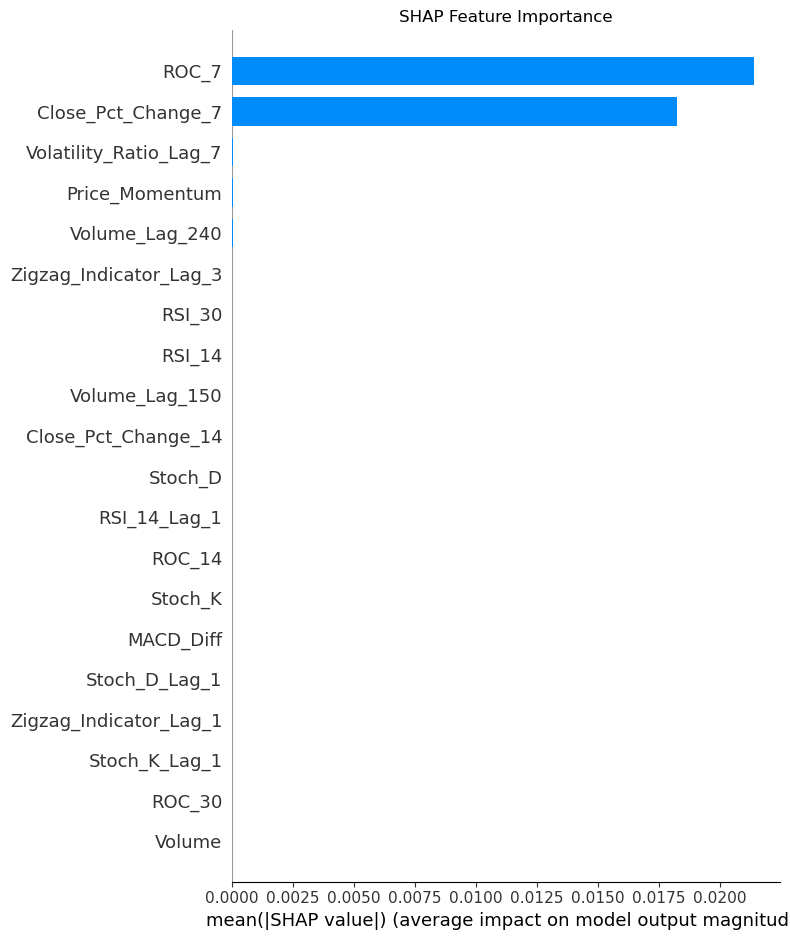

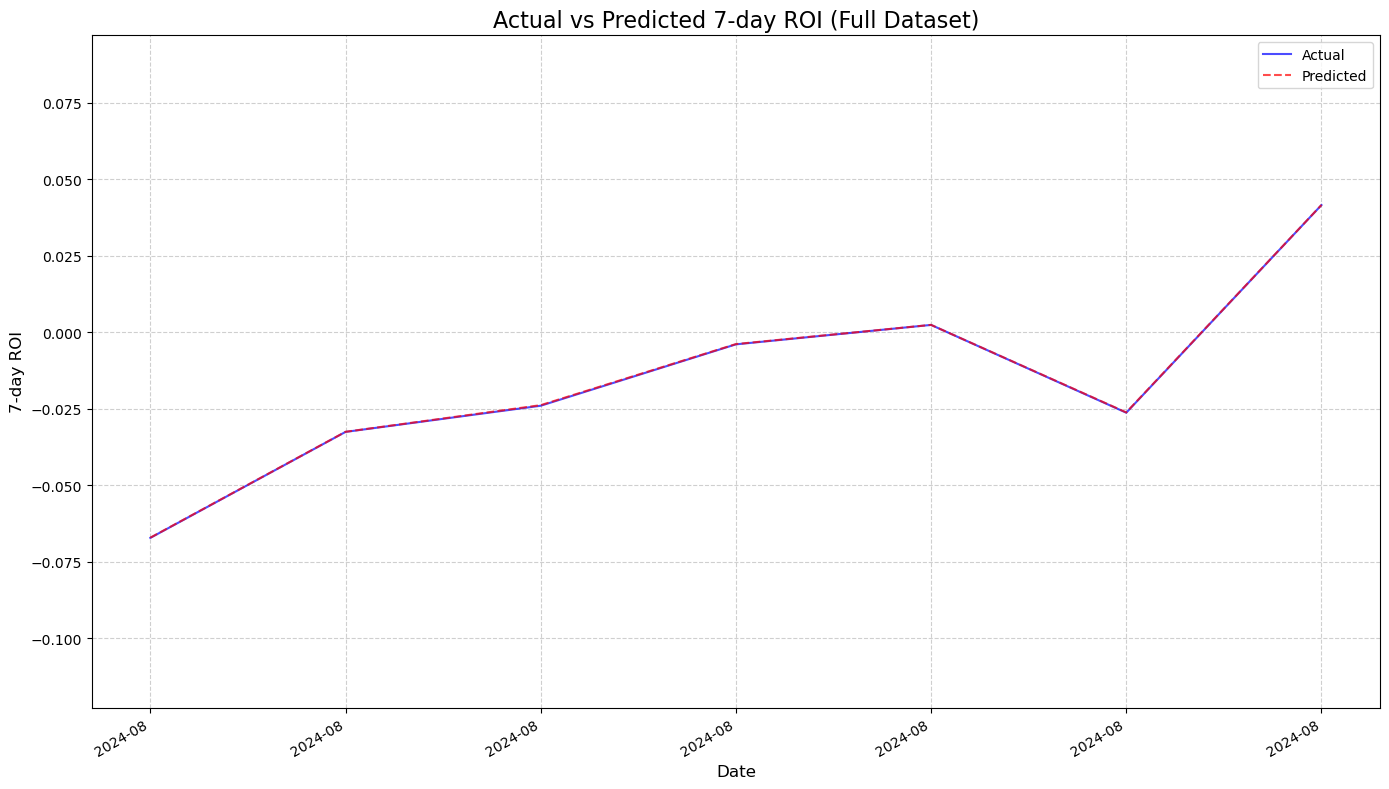

In [27]:
import matplotlib.dates as mdates

def predict_bitcoin_price(start_prediction_date):
    
    end_date = datetime.now().strftime("%Y-%m-%d")
    start_date = "2015-01-01"
    df = get_bitcoin_data_yfinance_format(start_date, end_date)

    if df.index.tz is None:
        df.index = df.index.tz_localize('UTC')
    pacific = pytz.timezone('US/Pacific')
    df.index = df.index.tz_convert(pacific)

    def plot_roi(data, title, start_date=None, end_date=None):
        if start_date:
            data = data.loc[data.index >= start_date]
        if end_date:
            data = data.loc[data.index <= end_date]
    
        plt.figure(figsize=(14, 8))
    
        plt.plot(data.index, data['Actual'], label='Actual', color='blue', alpha=0.7)
        plt.plot(data.index, data['Predicted'], label='Predicted', color='red', linestyle='--', alpha=0.7)
    
        plt.title(title, fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('7-day ROI', fontsize=12)
        plt.legend(fontsize=10)
    
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.gcf().autofmt_xdate()
    
        plt.grid(True, linestyle='--', alpha=0.6)
    
        y_min, y_max = plt.ylim()
        plt.ylim(y_min - 0.05, y_max + 0.05)
    
        plt.tight_layout()
        plt.show()

    start_prediction = start_prediction_date.replace(tzinfo=pacific)
    end_prediction = start_prediction + timedelta(days=7)

    df_plot = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

    latest_data = df[df.index <= start_prediction].iloc[-365:].copy()
    latest_data = engineer_features(latest_data)

    if not latest_data.empty:
        forecast_dates = [start_prediction + timedelta(days=i) for i in range(8)]
        forecast_results = []

        for forecast_date in forecast_dates:
            try:
                # Preparing data for the current forecast date
                latest_data_copy = latest_data.iloc[-1:].copy()
                latest_data_copy.index = [forecast_date]
                latest_data_copy['Sentiment'] = get_crypto_sentiment()

                missing_features = set(selected_features) - set(latest_data_copy.columns)
                if missing_features:
                    print(f"Warning: Missing features for date {forecast_date}: {missing_features}")
                    for feature in missing_features:
                        latest_data_copy[feature] = 0  

                latest_data_processed = preprocessor.transform(latest_data_copy[selected_features])

                # Making predictions using all models
                model_predictions = {
                    'Gradient Boosting': gb_best.predict(latest_data_processed)[0],
                    'XGBoost': xgb_best.predict(latest_data_processed)[0],
                    'LightGBM': lgb_best.predict(latest_data_processed)[0],
                    'Elastic Net': elastic_net.predict(latest_data_processed)[0],
                    'LSTM': lstm_model.predict(latest_data_processed.reshape((1, 1, latest_data_processed.shape[1])))[0][0],
                    'SARIMA': sarima_results.forecast(steps=1)[0],
                    'Exponential Smoothing': exp_smoothing_results.forecast(1)[0],
                    'Prophet': prophet_model.predict(prophet_model.make_future_dataframe(periods=1, freq='D')).iloc[-1]['yhat'],
                    'Ensemble': ensemble.predict(latest_data_processed)[0]
                }

                # Calculating ensemble prediction with dynamic weighting
                ensemble_weights = np.array(list(model_predictions.values()))
                ensemble_weights = 1 / (np.abs(ensemble_weights) + 1e-8)  # Avoid division by zero
                ensemble_weights /= np.sum(ensemble_weights)
                ensemble_prediction = sum(ensemble_weights[i] * pred for i, pred in enumerate(model_predictions.values()))

                # Storing forecast results
                forecast_results.append({
                    'Date': forecast_date,
                    'Prediction': ensemble_prediction,
                    'Classification': classify_prediction(ensemble_prediction)
                })

            except Exception as e:
                print(f"Error forecasting for {forecast_date}: {e}")
                forecast_results.append({
                    'Date': forecast_date,
                    'Prediction': np.nan,
                    'Classification': 'Unknown'
                })

            latest_data = pd.concat([latest_data, latest_data_copy])
            latest_data = engineer_features(latest_data)

        # Calculating 7-day ROI
        start_price = df[df.index <= start_prediction]['Close'].iloc[-1]
        end_price = start_price * np.prod([1 + result['Prediction'] for result in forecast_results])
        roi_7d = (end_price - start_price) / start_price

        print(f"\nBitcoin price at {start_prediction}: ${start_price:.2f} USD")
        print(f"Forecasted Bitcoin price at {end_prediction}: ${end_price:.2f} USD")
        print(f"Forecasted 7-day ROI: {roi_7d * 100:.2f}%")

        print("\nDaily predictions:")
        for result in forecast_results:
            print(f"Date: {result['Date']}, Daily ROI: {result['Prediction']*100:.2f}%, Classification: {result['Classification']}")

        # Feature importance analysis
        if hasattr(gb_best, 'feature_names_in_'):
            actual_features = gb_best.feature_names_in_
        elif len(selected_features) == len(gb_best.feature_importances_):
            actual_features = selected_features
        else:
            print("Warning: Number of features in the model doesn't match the number of selected features.")
            print("Using generic feature names.")
            actual_features = [f'feature_{i}' for i in range(len(gb_best.feature_importances_))]

        feature_importance = pd.DataFrame({
            'feature': actual_features,
            'importance': gb_best.feature_importances_
        }).sort_values('importance', ascending=False)

        print("\nTop 10 Most Important Features:")
        print(feature_importance.head(10))

        # SHAP values for model interpretability
        explainer = shap.TreeExplainer(gb_best)
        shap_values = explainer.shap_values(X_test)
        plt.figure(figsize=(12, 8))
        shap.summary_plot(shap_values, X_test, plot_type="bar", feature_names=actual_features, show=False)
        plt.title("SHAP Feature Importance")
        plt.tight_layout()
        plt.show()

        # Plot ROI
        plot_roi(df_plot, 'Actual vs Predicted 7-day ROI (Full Dataset)')

    else:
        print("Error: No data available for the specified date range.")



# Call the function with the desired start prediction date
predict_bitcoin_price(datetime(2024, 8, 22, 13, 0))